l### 设置屏幕宽度

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

### 1、导入tensorflow及相关模块，并设置 GPU 使用占比

In [2]:
import tensorflow as tf

print(tf.__version__)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"
# 获取物理gpu,cpu对象
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus, cpus)
# 设置当前程序的 物理可见设备范围
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')

#设置仅在需要时申请：
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

# 下面的方式是设置Tensorflow固定消耗GPU:0的2GB显存
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)

logical_gpus = tf.config.experimental.list_logical_devices('GPU')

print('物理gpu个数: ', len(gpus))
print('总的gpu个数，其中包括括虚拟Logical gpus: ', len(logical_gpus))

2.0.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
物理gpu个数:  2
总的gpu个数，其中包括括虚拟Logical gpus:  4


### 2、创建样本点和变量

In [3]:
num_inputs = 2
num_examples = 1000

with tf.device('/device:GPU:3'):
    w = tf.constant([[2, -3.4]])
    b = tf.constant([4.2])
    x = tf.random.normal([num_examples, num_inputs], mean=0, stddev=10)
    e = tf.random.normal([num_examples, num_inputs], mean=0, stddev=0.1)
    W = tf.Variable(tf.constant([5, 1]))
    B = tf.Variable(tf.constant([1]))
w
w.device

'/job:localhost/replica:0/task:0/device:GPU:3'

In [4]:
import random
from matplotlib import pyplot as plt
# 线性回归模型， y = 
# 生成数据,生成1000组数据


true_y = tf.matmul(x, tf.transpose(w)) + b
x, true_y
# 读取数据

(<tf.Tensor: id=7, shape=(1000, 2), dtype=float32, numpy=
 array([[-15.469094  ,  11.470774  ],
        [ -0.60849553,  -0.1017297 ],
        [  4.0281844 ,   5.8396955 ],
        ...,
        [ 13.129897  ,   2.4451344 ],
        [  1.2030863 ,   0.13313974],
        [  6.817519  ,  -1.5844028 ]], dtype=float32)>,
 <tf.Tensor: id=32, shape=(1000, 1), dtype=float32, numpy=
 array([[-6.57388229e+01],
        [ 3.32888985e+00],
        [-7.59859657e+00],
        [-1.74910202e+01],
        [ 3.99294472e+01],
        [-5.14413605e+01],
        [-8.26611042e+00],
        [-1.02326794e+01],
        [ 3.76083374e+01],
        [ 2.69754143e+01],
        [ 1.18282738e+01],
        [-2.33795547e+01],
        [-5.79622650e+01],
        [-5.26297874e+01],
        [ 6.50769043e+00],
        [-2.00790977e+00],
        [-7.68941650e+01],
        [ 9.08321075e+01],
        [ 1.75761890e+00],
        [ 4.88830376e+01],
        [-8.54137516e+00],
        [-6.15041542e+00],
        [-8.21594906e+00],
   

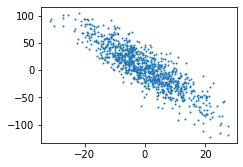

In [5]:
def set_figsize(figsize=(3.5, 2.5)):
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(x[: ,1], true_y, 1)

### 3、创建线性模型

In [6]:
class Mymodel():
    def __init__(self):
        self.w = tf.Variable([[2.3, 1.2]])
        self.b = tf.Variable([8.0])
    
    def __call__(self, x):
        self.y = tf.matmul(x , tf.transpose(self.w)) + self.b
        return self.y

### 4、数据处理及创建 batch_size 迭代器

In [7]:
def process(x, y):
    return x, y
    
db = tf.data.Dataset.from_tensor_slices((x, true_y))
db = db.shuffle(100)
db2 = db.map(process)
db_batch = db.batch(32)
# db_iter = next(iter(db_batch))
# print(db_iter[1].shape)

### 5、定义损失函数

In [8]:
def loss(predicted_y, desired_y):
    return tf.reduce_mean(tf.square(predicted_y - tf.reshape(desired_y, predicted_y.shape)))


### 6、定义一次损失计算及梯度更新训练

In [9]:
def train(model, inputs, outputs, learning_rate):    # 传入模型，输入，输出，及学习率
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
        print('loss',current_loss)
    dW, db = t.gradient(current_loss, [model.w, model.b])   # 梯度计算
    # tf.assign_sub(ref, value, use_locking=None, name=None)，变量 ref 减去 value值，即 ref = ref - value
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)


### 7、迭代训练

In [10]:
model = Mymodel()

Ws, bs = [], []
epoches = 20

steps = int(1000/32)
for i in range(epoches):
    for d in iter(db_batch):
#         d = next(iter(db_batch))
        it = d[0]
#         print(it)
        ot = d[1]
#         print(ot)
#         current_loss = loss(model(it), ot)
#         print(current_loss)

        train(model, it, ot, learning_rate=0.001)

    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())
    print('w',(Ws[-1]))
    print('b',(bs[-1]))
#         print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
#               (epoch, Ws[-1], bs[-1], current_loss))

loss tf.Tensor(1376.4008, shape=(), dtype=float32)
loss tf.Tensor(2606.1758, shape=(), dtype=float32)
loss tf.Tensor(649.0963, shape=(), dtype=float32)
loss tf.Tensor(573.4132, shape=(), dtype=float32)
loss tf.Tensor(506.1786, shape=(), dtype=float32)
loss tf.Tensor(261.406, shape=(), dtype=float32)
loss tf.Tensor(105.756195, shape=(), dtype=float32)
loss tf.Tensor(57.37858, shape=(), dtype=float32)
loss tf.Tensor(44.536655, shape=(), dtype=float32)
loss tf.Tensor(25.795221, shape=(), dtype=float32)
loss tf.Tensor(17.684303, shape=(), dtype=float32)
loss tf.Tensor(30.706358, shape=(), dtype=float32)
loss tf.Tensor(16.151934, shape=(), dtype=float32)
loss tf.Tensor(17.029266, shape=(), dtype=float32)
loss tf.Tensor(13.403906, shape=(), dtype=float32)
loss tf.Tensor(18.175167, shape=(), dtype=float32)
loss tf.Tensor(11.707448, shape=(), dtype=float32)
loss tf.Tensor(14.394793, shape=(), dtype=float32)
loss tf.Tensor(12.39275, shape=(), dtype=float32)
loss tf.Tensor(14.78525, shape=(), dt

loss tf.Tensor(8.112118, shape=(), dtype=float32)
w [[ 1.9723355 -3.4121807]]
b [6.9407787]
loss tf.Tensor(7.725419, shape=(), dtype=float32)
loss tf.Tensor(7.6603203, shape=(), dtype=float32)
loss tf.Tensor(7.760827, shape=(), dtype=float32)
loss tf.Tensor(7.4863863, shape=(), dtype=float32)
loss tf.Tensor(7.3917036, shape=(), dtype=float32)
loss tf.Tensor(7.412305, shape=(), dtype=float32)
loss tf.Tensor(7.311489, shape=(), dtype=float32)
loss tf.Tensor(7.3495235, shape=(), dtype=float32)
loss tf.Tensor(7.2753086, shape=(), dtype=float32)
loss tf.Tensor(7.113497, shape=(), dtype=float32)
loss tf.Tensor(7.090837, shape=(), dtype=float32)
loss tf.Tensor(7.6901355, shape=(), dtype=float32)
loss tf.Tensor(7.2679853, shape=(), dtype=float32)
loss tf.Tensor(7.120753, shape=(), dtype=float32)
loss tf.Tensor(7.3205476, shape=(), dtype=float32)
loss tf.Tensor(7.120695, shape=(), dtype=float32)
loss tf.Tensor(6.9846067, shape=(), dtype=float32)
loss tf.Tensor(7.356448, shape=(), dtype=float32)

loss tf.Tensor(2.9874074, shape=(), dtype=float32)
loss tf.Tensor(2.9382722, shape=(), dtype=float32)
loss tf.Tensor(2.8885803, shape=(), dtype=float32)
loss tf.Tensor(2.84698, shape=(), dtype=float32)
loss tf.Tensor(2.8567357, shape=(), dtype=float32)
loss tf.Tensor(3.0478263, shape=(), dtype=float32)
loss tf.Tensor(2.80097, shape=(), dtype=float32)
loss tf.Tensor(2.9585042, shape=(), dtype=float32)
loss tf.Tensor(2.8888903, shape=(), dtype=float32)
loss tf.Tensor(2.8967247, shape=(), dtype=float32)
loss tf.Tensor(2.8933167, shape=(), dtype=float32)
loss tf.Tensor(2.8944952, shape=(), dtype=float32)
loss tf.Tensor(2.8638945, shape=(), dtype=float32)
loss tf.Tensor(2.8491812, shape=(), dtype=float32)
loss tf.Tensor(2.7791114, shape=(), dtype=float32)
loss tf.Tensor(2.8496528, shape=(), dtype=float32)
loss tf.Tensor(2.8185604, shape=(), dtype=float32)
loss tf.Tensor(2.8021762, shape=(), dtype=float32)
loss tf.Tensor(2.7721202, shape=(), dtype=float32)
loss tf.Tensor(2.8149145, shape=(),

loss tf.Tensor(1.1453468, shape=(), dtype=float32)
loss tf.Tensor(1.1592574, shape=(), dtype=float32)
loss tf.Tensor(1.1616294, shape=(), dtype=float32)
loss tf.Tensor(1.185883, shape=(), dtype=float32)
loss tf.Tensor(1.1412241, shape=(), dtype=float32)
loss tf.Tensor(1.148283, shape=(), dtype=float32)
loss tf.Tensor(1.1654972, shape=(), dtype=float32)
loss tf.Tensor(1.1469151, shape=(), dtype=float32)
loss tf.Tensor(1.1491536, shape=(), dtype=float32)
loss tf.Tensor(1.1291233, shape=(), dtype=float32)
loss tf.Tensor(1.1336288, shape=(), dtype=float32)
loss tf.Tensor(1.1053963, shape=(), dtype=float32)
loss tf.Tensor(1.0494366, shape=(), dtype=float32)
w [[ 2.0119646 -3.392818 ]]
b [5.248531]


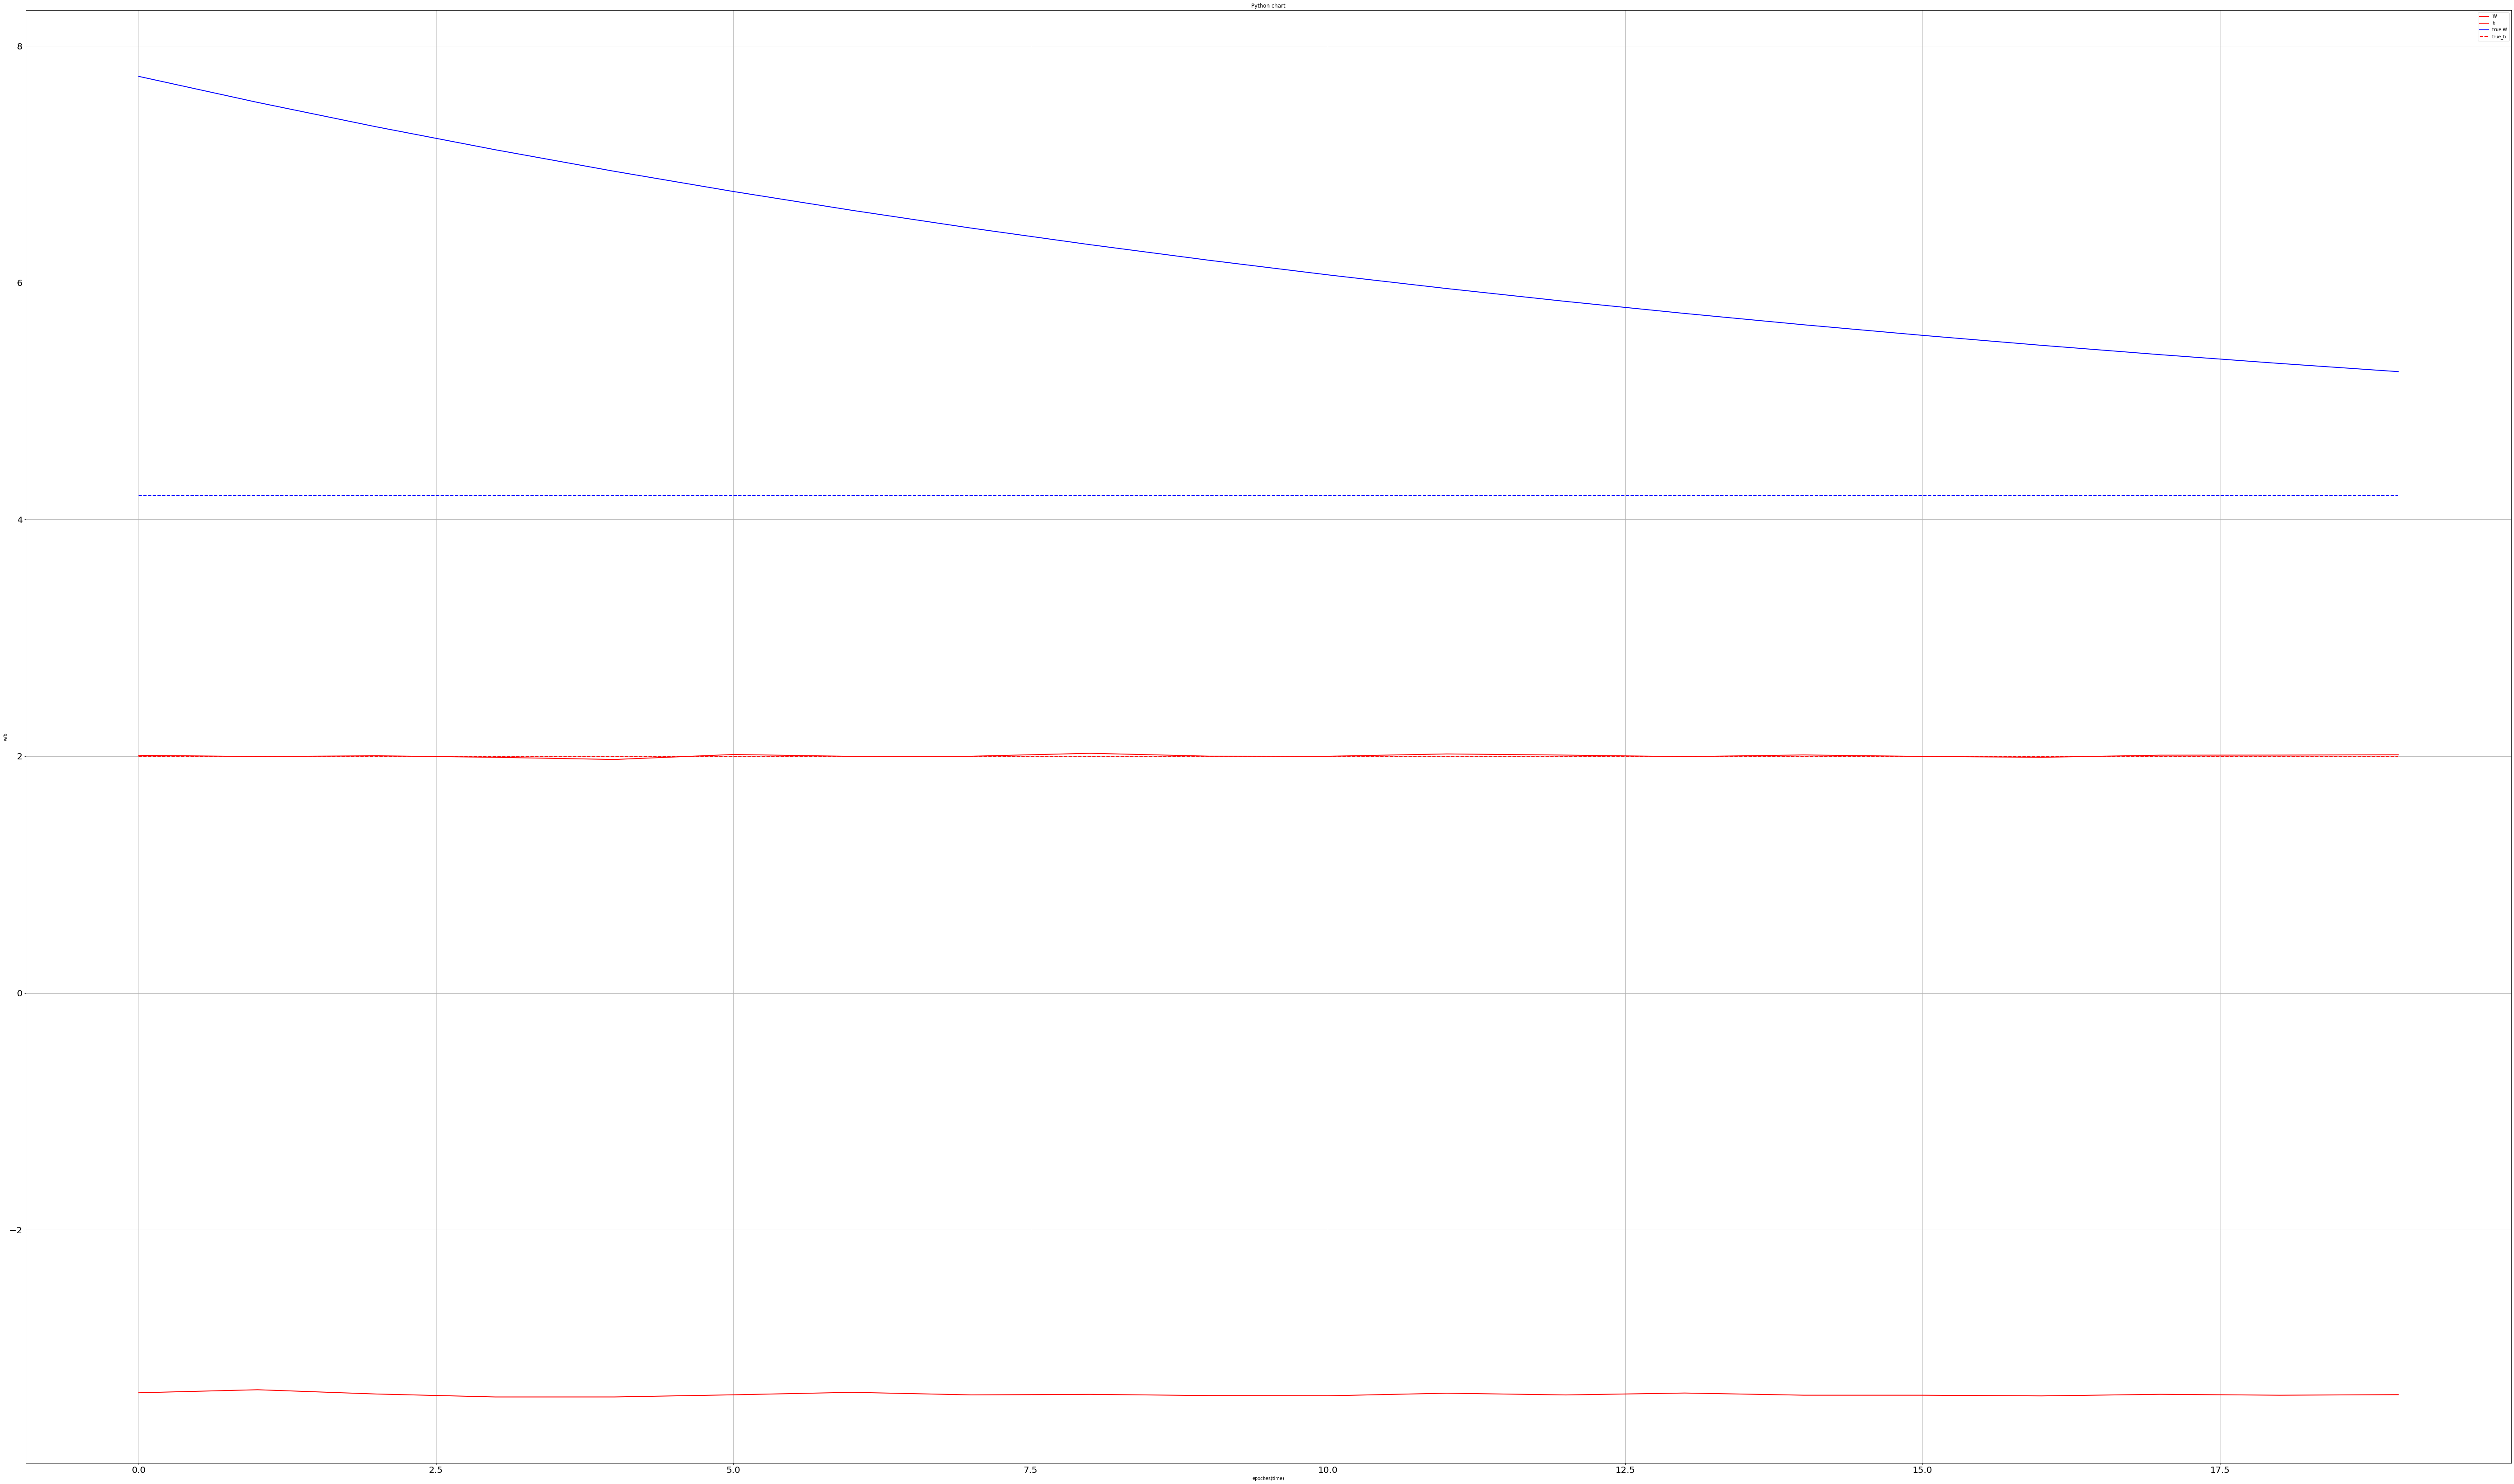

In [11]:
#     w = tf.constant([[2, -3.4]])
#     b = tf.constant([4.2])
# print(bs)
# plt.plot(epochs, Ws, 'r',
#          epochs, bs, 'b')
# plt.plot([TRUE_W] * len(epochs), 'r--',
#          [TRUE_b] * len(epochs), 'b--')
# plt.legend(['W', 'b', 'true W', 'true_b'])
# plt.show()


plt.figure(figsize=(100, 60))
plt.plot(range(epoches), [i[0] for i in Ws], 'r',
         range(epoches), [i[0] for i in bs], 'b', linewidth=2)
plt.plot([2] * epoches, 'r--',
         [4.2] * epoches, 'b--', linewidth=2)

plt.xlabel('epoches(time)')
plt.ylabel("w/b")
plt.grid(True)
plt.title("Python chart")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()